In [ ]:
!pip install xgboost
!pip install geopandas
!pip install folium
!pip install lightgbm
!pip install utm
!pip install geojson 
!pip install haversine

In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
import folium 
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import utm
from shapely.geometry import Point, Polygon
from haversine import haversine

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#평균 ver bike point 
df_data = pd.read_pickle('./모델학습용 데이터/Month_bikepoint_ALL_LSCP.pickle')
df_data.head()

,좌표,대여_월평균,반납_월평균,총 이용_월평균,스테이션,주거인구,버스_승하차수,지하철_승하차수,위도,경도,DN_avg,Road_yes,Space_count,Culture_count,Sport_count,KINTEX,Hosu_yes,Park_count,CD_01003_다가구주택,CD_02003_다세대주택,CD_03999_기타제1종근생,CD_03005_의원,CD_01001_단독주택,CD_13100_일반공장,CD_16006_정비공장,CD_03001_소매점,CD_17007_온실,CD_16010_주기장,CD_04001_일반음식점,CD_03104_소방서,CD_14999_기타창고시설,CD_04005_제조업소,CD_04010_학원,CD_04004_서점,CD_14001_창고,CD_04999_기타제2종근생,CD_19003_군사시설,CD_04006_수리점,CD_02002_연립주택,CD_01002_다중주택,...,221_count,250_count,260_count,290_count,310_count,320_count,330_count,390_count,500_count,520_count,기타 사회복지시설_count,초등학교_count,유치원_count,기타 체육시설_count,중학교_count,기타 도서관시설_count,청사(국가)_count,고등학교_count,공공체육시설_count,특수학교_count,각종학교_count,기타 공공직업훈련시설_count,대학_count,기타 운동장시설_count,지방자치단체_count,골프장_count,기타 연구시설_count,기타청소년수련시설_count,기타 문화시설_count,공관_count,박물관_count,기타 학교시설_count,종합운동장_count,노외주차장_count,공영차고지_count,기타 주차장시설_count,일반철도_count,기타철도시설_count,도시철도_count,여객자동차터미널_count
0,"(37.59052639593674, 126.88041634904563)",0.0,0.0,0.0,[155],74.0,0.0,0.0,37.590526,126.880416,16,1,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,1,0,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"(37.590546726423185, 126.88154829019997)",0.0,0.0,0.0,[155],36.0,0.0,0.0,37.590547,126.881548,17,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,"(37.59142713034578, 126.88039079257342)",0.0,0.0,0.0,[155],135.0,0.0,0.0,37.591427,126.880391,18,1,0,0,0,0,0,0,0,0,0,0,19,0,0,1,0,0,2,0,10,0,0,0,0,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,"(37.59144746148929, 126.88152274735107)",0.0,0.0,0.0,[155],82.0,0.0,0.0,37.591447,126.881523,21,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,6,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,"(37.59146778178655, 126.88265470326604)",0.0,0.0,0.0,[155],36.0,0.0,0.0,37.591468,126.882655,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df_data[['대여_월평균', '반납_월평균', '총 이용_월평균']].describe()

,대여_월평균,반납_월평균,총 이용_월평균
count,3233.000000,3233.000000,3233.000000
mean,509.677672,444.109123,953.786795
std,453.342976,431.308450,882.355074
min,0.000000,0.000000,0.000000
25%,190.194444,162.625000,350.611111
50%,348.722222,287.333333,633.750000
75%,749.166667,629.166667,1378.638889
max,2309.277778,2325.500000,4634.777778


In [ ]:
# 도시계획 전부 반영
df_target_all_plan = pd.read_csv('./모델학습용 데이터/Allpoint_LSCP_ALL.csv')
df_target_all_plan.head()

,Unnamed: 0,좌표,주거인구,버스_승하차수,지하철_승하차수,유동인구,위도,경도,DN_avg,Road_yes,Space_count,Culture_count,Sport_count,KINTEX,Hosu_yes,Park_count,CD_01003_다가구주택,CD_02003_다세대주택,CD_03999_기타제1종근생,CD_03005_의원,CD_01001_단독주택,CD_13100_일반공장,CD_16006_정비공장,CD_03001_소매점,CD_17007_온실,CD_16010_주기장,CD_04001_일반음식점,CD_03104_소방서,CD_14999_기타창고시설,CD_04005_제조업소,CD_04010_학원,CD_04004_서점,CD_14001_창고,CD_04999_기타제2종근생,CD_19003_군사시설,CD_04006_수리점,CD_02002_연립주택,CD_01002_다중주택,CD_04402_사무소,CD_04403_부동산중개업소,...,221_count,250_count,260_count,290_count,310_count,320_count,330_count,390_count,500_count,520_count,기타 사회복지시설_count,초등학교_count,유치원_count,기타 체육시설_count,중학교_count,기타 도서관시설_count,청사(국가)_count,고등학교_count,공공체육시설_count,특수학교_count,각종학교_count,기타 공공직업훈련시설_count,대학_count,기타 운동장시설_count,지방자치단체_count,골프장_count,기타 연구시설_count,기타청소년수련시설_count,기타 문화시설_count,공관_count,박물관_count,기타 학교시설_count,종합운동장_count,노외주차장_count,공영차고지_count,기타 주차장시설_count,일반철도_count,기타철도시설_count,도시철도_count,여객자동차터미널_count
0,0,"(37.57961579548528, 126.87506406643347)",12.0,53.0,0.0,53.0,37.579616,126.875064,25,1,0,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,"(37.57963617229605, 126.87619583846381)",12.0,0.0,0.0,0.0,37.579636,126.876196,25,1,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,7,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,"(37.57965653826528, 126.87732761163377)",12.0,0.0,0.0,0.0,37.579657,126.877328,21,1,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,7,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,"(37.58049614012486, 126.87390667102693)",12.0,61.0,0.0,61.0,37.580496,126.873907,17,1,0,0,0,0,0,0,0,0,3,0,9,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,"(37.5805165284361, 126.8750384555327)",12.0,61.0,0.0,61.0,37.580517,126.875038,16,1,0,0,0,0,0,0,0,0,3,0,7,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# 실현된 도시계획만 반영 
df_target_real_plan =pd.read_csv('./모델학습용 데이터/Targetpoint_LSCP_REAL.csv')
df_target_real_plan.head()

,좌표,주거인구,버스_승하차수,지하철_승하차수,유동인구,위도,경도,DN_avg,Road_yes,Space_count,Culture_count,Sport_count,KINTEX,Hosu_yes,Park_count,CD_01003_다가구주택,CD_02003_다세대주택,CD_03999_기타제1종근생,CD_03005_의원,CD_01001_단독주택,CD_13100_일반공장,CD_16006_정비공장,CD_03001_소매점,CD_17007_온실,CD_16010_주기장,CD_04001_일반음식점,CD_03104_소방서,CD_14999_기타창고시설,CD_04005_제조업소,CD_04010_학원,CD_04004_서점,CD_14001_창고,CD_04999_기타제2종근생,CD_19003_군사시설,CD_04006_수리점,CD_02002_연립주택,CD_01002_다중주택,CD_04402_사무소,CD_04403_부동산중개업소,CD_08102_중학교,...,221_count,250_count,260_count,290_count,310_count,320_count,330_count,390_count,500_count,520_count,기타 사회복지시설_count,초등학교_count,유치원_count,기타 체육시설_count,중학교_count,기타 도서관시설_count,청사(국가)_count,고등학교_count,공공체육시설_count,특수학교_count,각종학교_count,기타 공공직업훈련시설_count,대학_count,기타 운동장시설_count,지방자치단체_count,골프장_count,기타 연구시설_count,기타청소년수련시설_count,기타 문화시설_count,공관_count,박물관_count,기타 학교시설_count,종합운동장_count,노외주차장_count,공영차고지_count,기타 주차장시설_count,일반철도_count,기타철도시설_count,도시철도_count,여객자동차터미널_count
0,"(37.57961579548528, 126.87506406643347)",12.0,53.0,0.0,53.0,37.579616,126.875064,25,1,0,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"(37.57963617229605, 126.87619583846381)",12.0,0.0,0.0,0.0,37.579636,126.876196,25,1,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,7,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"(37.57965653826528, 126.87732761163377)",12.0,0.0,0.0,0.0,37.579657,126.877328,21,1,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,7,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,"(37.58049614012486, 126.87390667102693)",12.0,61.0,0.0,61.0,37.580496,126.873907,17,1,0,0,0,0,0,0,0,0,3,0,9,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"(37.5805165284361, 126.8750384555327)",12.0,61.0,0.0,61.0,37.580517,126.875038,16,1,0,0,0,0,0,0,0,0,3,0,7,0,0,0,0,0,0,0,8,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# 자전거 스테이션 정보 
station = pd.read_csv('./모델학습용 데이터/스테이션 월 별 이용.csv')
station.head()

,Station_ID,STATION_NAME,위도,경도,총 이용_월평균,대여_월평균,반납_월평균,거치대 수량
0,101,어울림마을 701동 앞,37.654775,126.834585,488.138889,232.388889,255.750000,20
1,103,대림e-편한세상106동,37.660442,126.840377,268.222222,125.972222,142.250000,20
2,104,탄현마을8단지,37.698523,126.766042,631.444444,372.277778,259.166667,25
3,105,KT 덕양지사 앞,37.655244,126.839261,152.833333,77.944444,74.888889,20
4,106,원당역 앞 공영주차장,37.653410,126.842530,188.916667,123.444444,65.472222,30


In [ ]:
admin_boundary = gpd.read_file('/content/drive/My Drive/Compas/compas/SBJ_2007_001/09.행정경계(읍면동).geojson')
admin_boundary['색깔'] = 0.5

# 도시계획

In [ ]:
# 전체 데이터에서 도시계획 관련 데이터 불러오기 
model_plan = df_data.copy()
plan_col = model_plan.columns[:12].append(model_plan.columns[-45:])
model_plan = model_plan[plan_col]
model_plan

,좌표,대여_월평균,반납_월평균,총 이용_월평균,스테이션,주거인구,버스_승하차수,지하철_승하차수,위도,경도,DN_avg,Road_yes,110_count,120_count,200_count,210_count,220_count,221_count,250_count,260_count,290_count,310_count,320_count,330_count,390_count,500_count,520_count,기타 사회복지시설_count,초등학교_count,유치원_count,기타 체육시설_count,중학교_count,기타 도서관시설_count,청사(국가)_count,고등학교_count,공공체육시설_count,특수학교_count,각종학교_count,기타 공공직업훈련시설_count,대학_count,기타 운동장시설_count,지방자치단체_count,골프장_count,기타 연구시설_count,기타청소년수련시설_count,기타 문화시설_count,공관_count,박물관_count,기타 학교시설_count,종합운동장_count,노외주차장_count,공영차고지_count,기타 주차장시설_count,일반철도_count,기타철도시설_count,도시철도_count,여객자동차터미널_count
0,"(37.59052639593674, 126.88041634904563)",0.00,0.000000,0.000000,[155],74.0,0.0,0.0,37.590526,126.880416,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"(37.590546726423185, 126.88154829019997)",0.00,0.000000,0.000000,[155],36.0,0.0,0.0,37.590547,126.881548,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,"(37.59142713034578, 126.88039079257342)",0.00,0.000000,0.000000,[155],135.0,0.0,0.0,37.591427,126.880391,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,"(37.59144746148929, 126.88152274735107)",0.00,0.000000,0.000000,[155],82.0,0.0,0.0,37.591447,126.881523,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,"(37.59146778178655, 126.88265470326604)",0.00,0.000000,0.000000,[155],36.0,0.0,0.0,37.591468,126.882655,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,"(37.70445091519225, 126.75467703178417)",169.25,127.277778,296.527778,[346],3562.0,5665.0,0.0,37.704451,126.754677,28,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3229,"(37.704472506609626, 126.75581060819373)",169.25,127.277778,296.527778,[346],2661.0,3486.0,0.0,37.704473,126.755811,27,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3230,"(37.70466633943072, 126.7660128502553)",118.25,101.500000,219.750000,[351],7713.0,21185.0,0.0,37.704666,126.766013,31,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3231,"(37.70468782197291, 126.76714643873707)",118.25,101.500000,219.750000,[351],6526.0,21185.0,0.0,37.704688,126.767146,33,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
model_plan.columns

Index(['좌표', '대여_월평균', '반납_월평균', '총 이용_월평균', '스테이션', '주거인구', '버스_승하차수',
       '지하철_승하차수', '위도', '경도', 'DN_avg', 'Road_yes', '110_count', '120_count',
       '200_count', '210_count', '220_count', '221_count', '250_count',
       '260_count', '290_count', '310_count', '320_count', '330_count',
       '390_count', '500_count', '520_count', '기타 사회복지시설_count', '초등학교_count',
       '유치원_count', '기타 체육시설_count', '중학교_count', '기타 도서관시설_count',
       '청사(국가)_count', '고등학교_count', '공공체육시설_count', '특수학교_count',
       '각종학교_count', '기타 공공직업훈련시설_count', '대학_count', '기타 운동장시설_count',
       '지방자치단체_count', '골프장_count', '기타 연구시설_count', '기타청소년수련시설_count',
       '기타 문화시설_count', '공관_count', '박물관_count', '기타 학교시설_count',
       '종합운동장_count', '노외주차장_count', '공영차고지_count', '기타 주차장시설_count',
       '일반철도_count', '기타철도시설_count', '도시철도_count', '여객자동차터미널_count'],
      dtype='object')

In [ ]:
# 0만 있는 column 제외 
zero_col = []
for x in model_plan.columns[18:]:
  if len(model_plan[str(x)].unique()) == 1:
    zero_col.append(x)

print(zero_col)
model_plan = model_plan.drop(zero_col, axis = 1)
model_plan.head()

['290_count', '390_count', '520_count', '각종학교_count', '공관_count', '박물관_count']


,좌표,대여_월평균,반납_월평균,총 이용_월평균,스테이션,주거인구,버스_승하차수,지하철_승하차수,위도,경도,DN_avg,Road_yes,110_count,120_count,200_count,210_count,220_count,221_count,250_count,260_count,310_count,320_count,330_count,500_count,기타 사회복지시설_count,초등학교_count,유치원_count,기타 체육시설_count,중학교_count,기타 도서관시설_count,청사(국가)_count,고등학교_count,공공체육시설_count,특수학교_count,기타 공공직업훈련시설_count,대학_count,기타 운동장시설_count,지방자치단체_count,골프장_count,기타 연구시설_count,기타청소년수련시설_count,기타 문화시설_count,기타 학교시설_count,종합운동장_count,노외주차장_count,공영차고지_count,기타 주차장시설_count,일반철도_count,기타철도시설_count,도시철도_count,여객자동차터미널_count
0,"(37.59052639593674, 126.88041634904563)",0.0,0.0,0.0,[155],74.0,0.0,0.0,37.590526,126.880416,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"(37.590546726423185, 126.88154829019997)",0.0,0.0,0.0,[155],36.0,0.0,0.0,37.590547,126.881548,17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,"(37.59142713034578, 126.88039079257342)",0.0,0.0,0.0,[155],135.0,0.0,0.0,37.591427,126.880391,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,"(37.59144746148929, 126.88152274735107)",0.0,0.0,0.0,[155],82.0,0.0,0.0,37.591447,126.881523,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,"(37.59146778178655, 126.88265470326604)",0.0,0.0,0.0,[155],36.0,0.0,0.0,37.591468,126.882655,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 도시계획_실재 데이터
target_plan_col = plan_col.drop(['좌표','위도', '경도','대여_월평균','반납_월평균','총 이용_월평균','스테이션'])
target_plan_col = target_plan_col.drop(zero_col) #0인 columns 제외 
X_target_real = df_target_real_plan.drop(['좌표',  '유동인구','위도', '경도'], axis =1) # X 데이터 만들기 
X_target_real = X_target_real[target_plan_col]

In [ ]:
# 도시계획_전체 데이터 
target_plan_col = plan_col.drop(['좌표','위도', '경도','대여_월평균','반납_월평균','총 이용_월평균','스테이션'])
target_plan_col = target_plan_col.drop(zero_col) # 0인 columns 제외 
X_target_all = df_target_all_plan.drop(['좌표',  '유동인구','위도', '경도'], axis =1) # X 데이터 만들기 
X_target_all = X_target_all[target_plan_col]

In [ ]:
# 학습 데이터 준비 
y = model_plan['총 이용_월평균']
X = model_plan.drop(['좌표', '대여_월평균', '반납_월평균', '총 이용_월평균', '스테이션', '위도', '경도'], axis =1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.1)

print(X_train.shape, X_test.shape, y_train.shape)

(2909, 44) (324, 44) (2909,)


In [ ]:
#학습 데이터와 예측할 데이터 차원 비교  
X.shape, X_target_real.shape, X_target_all.shape

((3233, 44), (17604, 44), (20837, 44))

In [ ]:
# 모델 학습 
import xgboost as xgb

xgb_model = xgb.XGBRegressor(booster = 'gbtree', 
                       colsample_bytree= 0.5, 
                       gamma = 0.0, 
                       learning_rate = 0.05, 
                       max_depth =  7, 
                       min_child_weight = 1, 
                        n_estimators =1000, 
                       random_state= 545, 
                       subsample=1.0,
                       objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)

print('train R2 score : {}'.format(xgb_model.score(X_train, y_train)))
print('test R2 score : {}'.format(xgb_model.score(X_test, y_test)))

# MSE와 y의 표준편차 비교 mean_squared_error(y_true, y_pred)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
std = y_test.std()

print('rmse:',rmse)
print('std:',std) 

train R2 score : 0.994685991931522
test R2 score : 0.8852221248887618
rmse: 304.05963090241585
std: 898.8783446375515
rmse/std: 0.3382656092633088


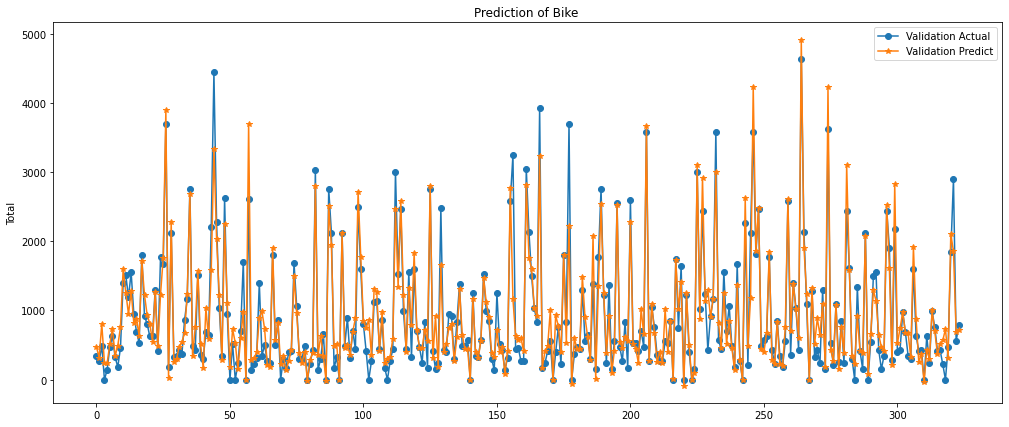

In [ ]:
# Test 데이터: 예측과 실제값 비교 
pred_val = xgb_model.predict(X_test)

plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_test)), y_test,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '*-', label='Validation Predict')
plt.title('Prediction of Bike ')
plt.ylabel('Total')
plt.legend()

In [ ]:
# 특성 중요도 확인 
feature_important = [ X.columns[i] for i in np.argsort(xgb_model.feature_importances_)[::-1]]
feature_important

['청사(국가)_count',
 '기타청소년수련시설_count',
 '지하철_승하차수',
 'Road_yes',
 '공영차고지_count',
 '여객자동차터미널_count',
 '기타 운동장시설_count',
 '220_count',
 '도시철도_count',
 '노외주차장_count',
 '기타 주차장시설_count',
 '일반철도_count',
 '특수학교_count',
 '유치원_count',
 '고등학교_count',
 '500_count',
 '기타철도시설_count',
 'DN_avg',
 '대학_count',
 '중학교_count',
 '기타 도서관시설_count',
 '종합운동장_count',
 '250_count',
 '기타 문화시설_count',
 '210_count',
 '골프장_count',
 '200_count',
 '지방자치단체_count',
 '기타 사회복지시설_count',
 '110_count',
 '초등학교_count',
 '310_count',
 '버스_승하차수',
 '기타 체육시설_count',
 '주거인구',
 '320_count',
 '기타 학교시설_count',
 '330_count',
 '기타 연구시설_count',
 '공공체육시설_count',
 '기타 공공직업훈련시설_count',
 '260_count',
 '221_count',
 '120_count']

In [ ]:
importances = np.sort(xgb_model.feature_importances_)[::-1]
feature_list = pd.DataFrame([feature_important, importances]).T
feature_list.columns = ['features_name', 'importance']
feature_list

,features_name,importance
0,청사(국가)_count,0.121541
1,기타청소년수련시설_count,0.120791
2,지하철_승하차수,0.0680448
3,Road_yes,0.0617693
4,공영차고지_count,0.0470971
5,여객자동차터미널_count,0.0421976
6,기타 운동장시설_count,0.031876
7,220_count,0.0304582
8,도시철도_count,0.0271654
9,노외주차장_count,0.026714


In [ ]:
feature_list.to_csv('도시계획_특성 중요도.csv', index = False)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_

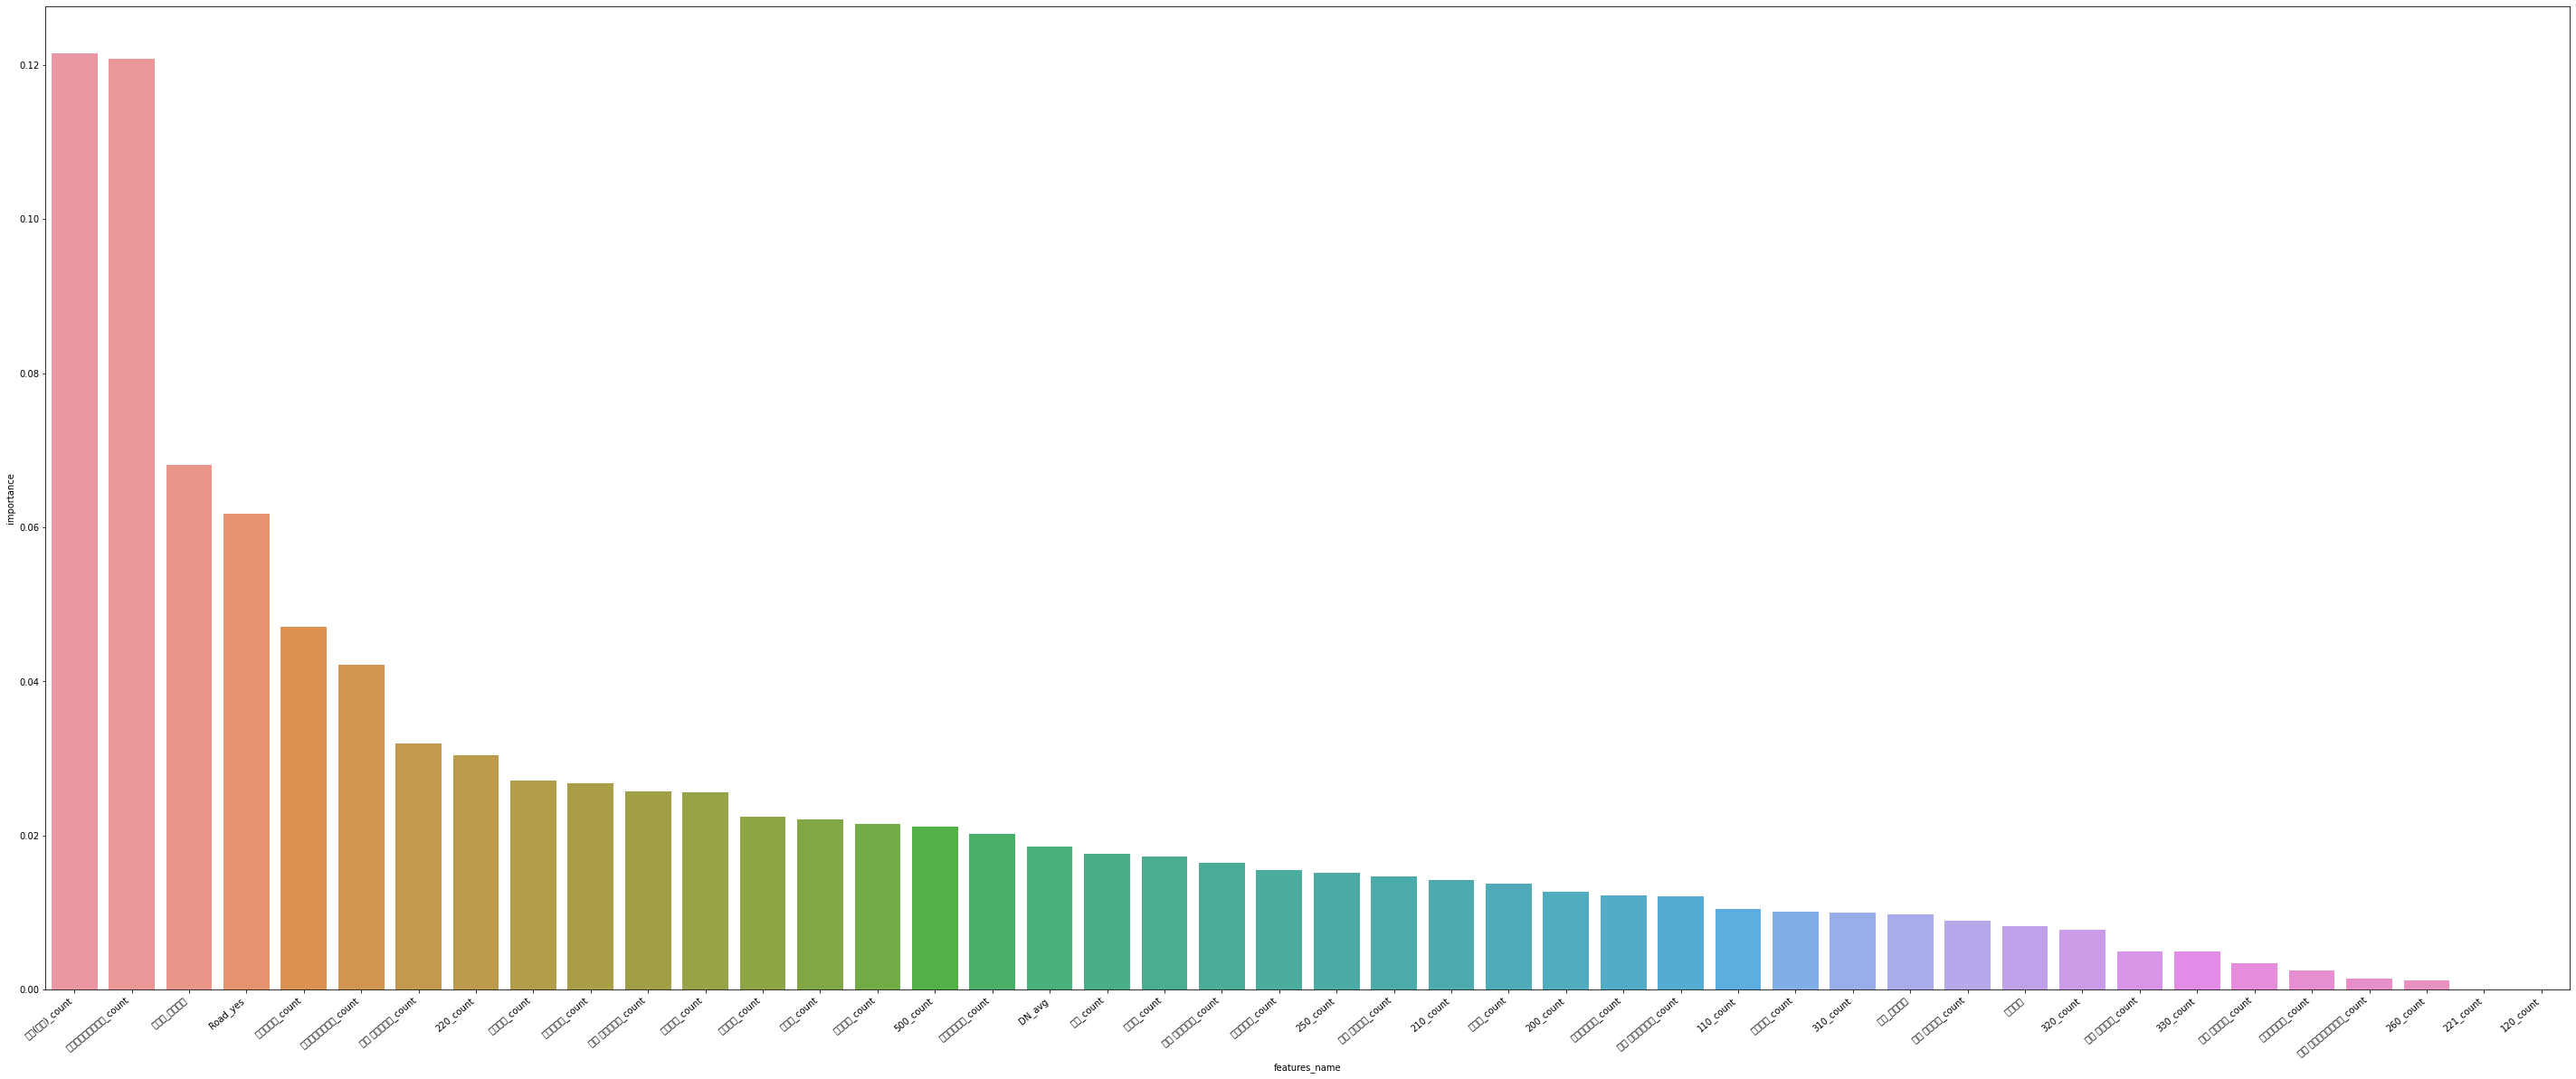

In [ ]:
plt.figure(figsize = (50,20))
ax = sns.barplot(x = feature_list['features_name'], y = feature_list['importance'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

fig = plt.gcf()
fig.savefig('graph.png', dpi=300, format='png', bbox_inches="tight", facecolor="white")


In [ ]:
# 도시계획_실재 데이터 에측 
df_target_real_plan['예상 수요'] = pd.Series(xgb_model.predict(X_target_real))
df_target_real_plan['예상 수요'] .describe()

count    17604.000000
mean       399.166016
std        601.430908
min       -256.298218
25%         38.272927
50%        173.317917
75%        540.566650
max       4681.143066
Name: 예상 수요, dtype: float64

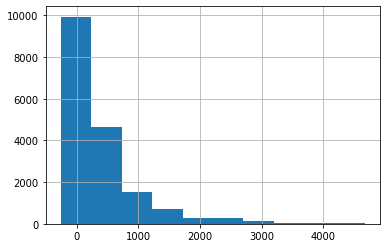

In [ ]:
df_target_real_plan['예상 수요'].hist()

In [ ]:
# 도시 계획_실재 데이터에 예상 수요 column 추가 
result_real = pd.concat([df_target_real_plan[['좌표', '예상 수요']], df_target_real_plan[feature_important]], axis = 1) #특성 중요도 순으로 재배열 
result_real.head()

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count
0,"(37.57961579548528, 126.87506406643347)",127.305229,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.0,0,12.0,0,0,0,0,0,0,0,0,0
1,"(37.57963617229605, 126.87619583846381)",84.771622,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0
2,"(37.57965653826528, 126.87732761163377)",79.219406,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0
3,"(37.58049614012486, 126.87390667102693)",178.742996,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,0,0,0,0,0,0,0,0,0
4,"(37.5805165284361, 126.8750384555327)",169.560989,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,0,0,0,0,0,0,0,0,0


In [ ]:
# 도시계획_전체 데이터 예측 
df_target_all_plan['예상 수요'] = xgb_model.predict(X_target_all)
df_target_all_plan['예상 수요'] = pd.Series(df_target_all_plan['예상 수요'])
df_target_all_plan['예상 수요'].describe()

count    20837.000000
mean       480.721802
std        656.304688
min       -407.361145
25%         52.869137
50%        246.272293
75%        644.957703
max       4517.607910
Name: 예상 수요, dtype: float64

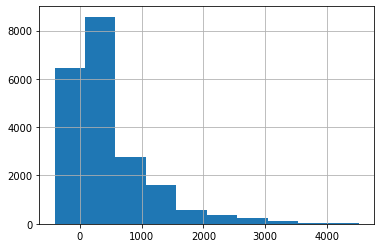

In [ ]:
df_target_all_plan['예상 수요'].hist()

In [ ]:
# 도시 계획_전체 데이터에 예상 수요 column 추가 
result_all = pd.concat([df_target_all_plan[['좌표', '예상 수요']], df_target_all_plan[feature_important]], axis = 1) #특성 중요도 순으로 재배열 
result_all

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count
0,"(37.57961579548528, 126.87506406643347)",141.874710,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.0,0,12.0,1,0,0,0,0,0,0,0,0
1,"(37.57963617229605, 126.87619583846381)",84.771622,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0
2,"(37.57965653826528, 126.87732761163377)",79.219406,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0
3,"(37.58049614012486, 126.87390667102693)",164.714020,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,3,0,0,0,0,0,0,0,0
4,"(37.5805165284361, 126.8750384555327)",162.478241,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20832,"(37.74702008221923, 126.91341083764837)",53.696995,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,0,0.0,0,0,0,0,0,0,0,0,0
20833,"(37.747040166676285, 126.91454518217792)",53.696995,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,0,0.0,0,0,0,0,0,0,0,0,0
20834,"(37.74706024022562, 126.9156795278339)",53.696995,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,273,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.0,0,0.0,0,0,0,0,0,0,0,0,0
20835,"(37.60951982027619, 126.83456514393055)",881.649231,0,0,5568132.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0.0,0,0,0,0,0,0,0,0,0


In [ ]:
# 도시계획_실재 -> 예측 수요 추가 파일 저장 
result_all.to_csv('./도시계획_예상수요_ALLplan.csv', index = False)

In [ ]:
# 도시계획_전체 -> 예측 수요 추가 파일 저장 
result_real.to_csv('./도시계획_예상수요_REALplan.csv', index = False)

In [ ]:
# real.to_csv('./도시계획_실제수요.csv', index = False)

# 예측 수요 시각화

In [ ]:
admin_boundary = gpd.read_file('/content/drive/My Drive/Compas/compas/SBJ_2007_001/09.행정경계(읍면동).geojson')
admin_boundary['색깔'] = 1

In [ ]:
df_target_all_plan = pd.read_csv('./도시계획_예상수요_ALLplan.csv')

mapper = lambda x: float(x.strip('\(').strip('\)').split(',')[0])
df_target_all_plan['위도'] = df_target_all_plan['좌표'].map(mapper)

mapper = lambda x: float(x.strip('\(').strip('\)').split(',')[1])
df_target_all_plan['경도'] = df_target_all_plan['좌표'].map(mapper)

df_target_all_plan.head()

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count,위도,경도
0,"(37.57961579548528, 126.87506406643347)",141.874710,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.0,0,12.0,1,0,0,0,0,0,0,0,0,37.579616,126.875064
1,"(37.57963617229605, 126.87619583846381)",84.771620,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0,37.579636,126.876196
2,"(37.57965653826528, 126.87732761163377)",79.219406,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0,37.579657,126.877328
3,"(37.58049614012486, 126.87390667102693)",164.714020,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,3,0,0,0,0,0,0,0,0,37.580496,126.873907
4,"(37.5805165284361, 126.8750384555327)",162.478240,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,1,0,0,0,0,0,0,0,0,37.580517,126.875038


In [ ]:
df_target_real_plan = pd.read_csv('./도시계획_예상수요_REALplan.csv')

mapper = lambda x: float(x.strip('\(').strip('\)').split(',')[0])
df_target_real_plan['위도'] = df_target_real_plan['좌표'].map(mapper)

mapper = lambda x: float(x.strip('\(').strip('\)').split(',')[1])
df_target_real_plan['경도'] = df_target_real_plan['좌표'].map(mapper)

df_target_real_plan.head()

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count,위도,경도
0,"(37.57961579548528, 126.87506406643347)",127.305230,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.0,0,12.0,0,0,0,0,0,0,0,0,0,37.579616,126.875064
1,"(37.57963617229605, 126.87619583846381)",84.771620,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0,37.579636,126.876196
2,"(37.57965653826528, 126.87732761163377)",79.219406,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,12.0,0,0,0,0,0,0,0,0,0,37.579657,126.877328
3,"(37.58049614012486, 126.87390667102693)",178.743000,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,0,0,0,0,0,0,0,0,0,37.580496,126.873907
4,"(37.5805165284361, 126.8750384555327)",169.560990,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61.0,0,12.0,0,0,0,0,0,0,0,0,0,37.580517,126.875038


In [ ]:
# 자전거 스테이션 이용 
station['총 이용_월평균'].describe()

count     155.000000
mean     1071.507478
std       949.915079
min        48.527778
25%       421.986111
50%       717.194444
75%      1468.847222
max      4634.777778
Name: 총 이용_월평균, dtype: float64

In [ ]:
# 스테이션 
D_q25 = station['총 이용_월평균'].quantile(0.25)
D_q50= station['총 이용_월평균'].quantile(0.5)
D_q75 = station['총 이용_월평균'].quantile(0.75)
D_q85 = station['총 이용_월평균'].quantile(0.85)

station['총 이용 분위수'] = station['총 이용_월평균'].map(lambda x: 
                                          1 if x <=D_q25 
                                          else 2 if (D_q25 <= x)  & (x <= D_q50)
                                          else 3 if (D_q50 <= x)  & (x <= D_q75)
                                          else 4 if (D_q75 <= x)  & (x <= D_q85)
                                          else 5)
station

,Station_ID,STATION_NAME,위도,경도,총 이용_월평균,대여_월평균,반납_월평균,거치대 수량,총 이용 분위수
0,101,어울림마을 701동 앞,37.654775,126.834585,488.138889,232.388889,255.750000,20,2
1,103,대림e-편한세상106동,37.660442,126.840377,268.222222,125.972222,142.250000,20,1
2,104,탄현마을8단지,37.698523,126.766042,631.444444,372.277778,259.166667,25,2
3,105,KT 덕양지사 앞,37.655244,126.839261,152.833333,77.944444,74.888889,20,1
4,106,원당역 앞 공영주차장,37.653410,126.842530,188.916667,123.444444,65.472222,30,1
...,...,...,...,...,...,...,...,...,...
150,348,★하이파크3단지 302동앞 버스정류장옆,37.699353,126.754793,207.666667,126.416667,81.250000,30,1
151,349,★고양시 여성창업지원센터 옆,37.697838,126.752642,385.222222,209.222222,176.000000,20,1
152,350,★하이파크5단지 502동앞 버스정류장,37.697867,126.753089,218.111111,116.388889,101.722222,20,1
153,351,◆일산에듀포레 푸르지오,37.702259,126.767231,219.750000,118.250000,101.500000,40,1


In [ ]:
# 도시계획_실재 -> 예상 수요 
pred_demand_real = df_target_real_plan['예상 수요']
pred_demand_real.describe()

count    17604.000000
mean       399.165476
std        601.433029
min       -256.298220
25%         38.272927
50%        173.317915
75%        540.566648
max       4681.143000
Name: 예상 수요, dtype: float64

In [ ]:
# 도시계획_실재 예상 수요 분위수 
q1 = pred_demand_real.quantile(0.25)
q2 = pred_demand_real.quantile(0.5)
q3 = pred_demand_real.quantile(0.75)
q4 = D_q50 #자전거 스테이션 median 

df_target_real_plan['예상 수요'] = pred_demand_real
df_target_real_plan['예상 수요 분위수'] = pred_demand_real.map(lambda x: 
                                          1 if x <=q1
                                          else 2 if (q1 <= x)  & (x <= q2)
                                          else 3 if (q2 <= x)  & (x <= q3)
                                          else 4 if (q3 <= x)  & (x <= q4)
                                          else 5)

In [ ]:
# 도시계획_전체 예측 수요 
pred_demand_all = df_target_all_plan['예상 수요']
pred_demand_all.describe()

count    20837.000000
mean       480.720162
std        656.304233
min       -407.361150
25%         52.869137
50%        246.272300
75%        644.957700
max       4517.608000
Name: 예상 수요, dtype: float64

In [ ]:
# 도시계획_전체 예상 수요 분위수 
q1 = pred_demand_all.quantile(0.25)
q2 = pred_demand_all.quantile(0.5)
q3 = pred_demand_all.quantile(0.75)
q4 = D_q50 # 자전거 스테이션 median

# df_target_all_plan['예상 수요'] = pred_demand_all
df_target_all_plan['예상 수요 분위수'] = pred_demand_all.map(lambda x: 
                                          1 if x <=q1
                                          else 2 if (q1 <= x)  & (x <= q2)
                                          else 3 if (q2 <= x)  & (x <= q3)
                                          else 4 if (q3 <= x)  & (x <= q4)
                                          else 5)

In [ ]:
# 도시계획_실재 수요 시각화 

# # 100m 기준 격자 
import folium 
from folium import plugins

m = folium.Map(location=(37.66714305514331, 126.82008045013437), zoom_start=13)
#읍면동 경계 출력 
folium.Choropleth(
    geo_data = admin_boundary,
    data = admin_boundary,
    columns = ('EMD_KOR_NM', '색깔'),
    key_on = 'feature.properties.EMD_KOR_NM',
    fill_color = 'BuPu',
    legend_name = '색깔'
).add_to(m) 

# 각 좌표의 예상 수요 분위수에 따라 색 분류
for sub_lat, sub_long, quan, D in zip(df_target_real_plan['위도'], df_target_real_plan['경도'], df_target_real_plan['예상 수요 분위수'], df_target_real_plan['예상 수요']): 
  if quan == 1:
    color = 'white'
  elif quan == 2:
    color = 'yellow'
  elif quan == 3:
    color = 'green'
  elif quan == 4:
    color = 'blue'
  elif quan == 5:
    color = 'red'
  else:
    color = 'black'
  folium.CircleMarker([sub_lat, sub_long],
       tooltip = '{:.2f}'.format(D) ,radius = 0.00000002, color = color ).add_to(m)

# 각 스테이션 마커에 스테이션 분위수 표시 
for index, row in station.iterrows():
  title = "{}:{}:거치대 {} || 총 {:.2f}- 대여 {:.2f} - 반납 {:.2f}".format(row['Station_ID'],row['STATION_NAME'],row['거치대 수량'],row['총 이용_월평균'], row['대여_월평균'], row['반납_월평균'])
  if row['총 이용 분위수'] == 1:
    icon_number = plugins.BeautifyIcon( border_color='#00a8cc', text_color='#00a8cc', number=1, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 2:
    icon_number = plugins.BeautifyIcon( border_color='#3282b8', text_color='#3282b8', number=2, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  
  if row['총 이용 분위수'] == 3:
    icon_number = plugins.BeautifyIcon( border_color='#0f4c75', text_color='#0f4c75', number=3, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 4:
    icon_number = plugins.BeautifyIcon( border_color='#f38181', text_color='#f38181', number=4, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 5:
    icon_number = plugins.BeautifyIcon( border_color='#ff2e63', text_color='#ff2e63', number=5, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
 m.save('./도시계획_예상수요_REALplan.html')

In [ ]:
# 도시계획_전체 예상수요 시각화 
import folium 
from folium import plugins

m = folium.Map(location=(37.66714305514331, 126.82008045013437), zoom_start=13)

#읍면동 경계 
folium.Choropleth(
    geo_data = admin_boundary,
    data = admin_boundary,
    columns = ('EMD_KOR_NM', '색깔'),
    key_on = 'feature.properties.EMD_KOR_NM',
    fill_color = 'BuPu',
    legend_name = '색깔'
).add_to(m)

#도시계획_전체 수요 시각화 (분위수 별로 색깔 구분)
for sub_lat, sub_long, quan, D in zip(df_target_all_plan['위도'], df_target_all_plan['경도'], df_target_all_plan['예상 수요 분위수'], df_target_all_plan['예상 수요']): 
  if quan == 1:
    color = 'white'
  elif quan == 2:
    color = 'yellow'
  elif quan == 3:
    color = 'green'
  elif quan == 4:
    color = 'blue'
  elif quan == 5:
    color = 'red'
  else:
    color = 'black'
  folium.CircleMarker([sub_lat, sub_long],
       tooltip = '{:.2f}'.format(D) ,radius = 0.00000002, color = color ).add_to(m)

# 자전거 스테이션 위치 시각화 
for index, row in station.iterrows():
  title = "{}:{}:거치대 {} || 총 {:.2f}- 대여 {:.2f} - 반납 {:.2f}".format(row['Station_ID'],row['STATION_NAME'],row['거치대 수량'],row['총 이용_월평균'], row['대여_월평균'], row['반납_월평균'])
  # title = "Station {}: # of bike {} || Total {:.2f} - Rental {:.2f} - Return {:.2f}".format(row['Station_ID'],row['거치대 수량'],row['총 이용_월평균'], row['대여_월평균'], row['반납_월평균'])
  if row['총 이용 분위수'] == 1:
    icon_number = plugins.BeautifyIcon( border_color='#00a8cc', text_color='#00a8cc', number=1, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 2:
    icon_number = plugins.BeautifyIcon( border_color='#3282b8', text_color='#3282b8', number=2, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  
  if row['총 이용 분위수'] == 3:
    icon_number = plugins.BeautifyIcon( border_color='#0f4c75', text_color='#0f4c75', number=3, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 4:
    icon_number = plugins.BeautifyIcon( border_color='#f38181', text_color='#f38181', number=4, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

  if row['총 이용 분위수'] == 5:
    icon_number = plugins.BeautifyIcon( border_color='#ff2e63', text_color='#ff2e63', number=5, inner_icon_style='margin-top:0;')
    folium.Marker([row['위도'], row['경도']], tooltip=title, icon=icon_number).add_to(m)  

m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
 m.save('./도시계획_예상수요_ALLplan.html')

### 특정 지역 수요 시각화

In [ ]:
# 행정경계 데이터 불러오기 
dong_boundary = gpd.read_file('/content/drive/My Drive/Compas/compas/SBJ_2007_001/09.행정경계(읍면동).geojson')
dong_boundary['색깔'] = 1
dong_boundary

,EMD_CD,EMD_KOR_NM,geometry,색깔
0,41281101,주교동,"MULTIPOLYGON (((126.81068 37.65820, 126.81069 ...",1
1,41281102,원당동,"MULTIPOLYGON (((126.83321 37.68013, 126.83340 ...",1
2,41281103,신원동,"MULTIPOLYGON (((126.86362 37.67729, 126.86364 ...",1
3,41281104,원흥동,"MULTIPOLYGON (((126.85975 37.65081, 126.85990 ...",1
4,41281105,도내동,"MULTIPOLYGON (((126.84806 37.62348, 126.84835 ...",1
5,41281106,성사동,"MULTIPOLYGON (((126.83047 37.64860, 126.83053 ...",1
6,41281107,북한동,"MULTIPOLYGON (((126.95320 37.65582, 126.95334 ...",1
7,41281108,효자동,"MULTIPOLYGON (((126.94756 37.65922, 126.94777 ...",1
8,41281109,지축동,"MULTIPOLYGON (((126.89619 37.65389, 126.89627 ...",1
9,41281110,오금동,"MULTIPOLYGON (((126.89197 37.67066, 126.89222 ...",1


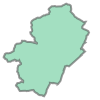

In [ ]:
# 주교동 경계 
jugyo_geometry = dong_boundary['geometry'].iloc[0]
jugyo_geometry

In [ ]:
# 입력한 target 데이터 중 해당 지역만 추출
def check_dong_index(df_target, dong_geometry):
  count = 0
  index_list = []

  for idx, (y_lat, y_long) in enumerate(zip(df_target['위도'], df_target['경도'])):
    if dong_geometry.contains(Point(y_long, y_lat)):
      index_list.append(idx)
      count += 1
      
  return df_target.iloc[index_list]

In [ ]:
jugyo = check_dong_index(df_target_real_plan, jugyo_geometry)
jugyo

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count,위도,경도,예상 수요 분위수
4640,"(37.64536013697522, 126.82332454358104)",83.061890,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,396.0,0,83.0,0,0,0,0,0,0,0,0,0,37.645360,126.823325,2
4642,"(37.645381040701785, 126.82445727389282)",213.087700,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,396.0,0,69.0,0,0,0,0,0,0,0,0,0,37.645381,126.824457,3
4644,"(37.645401933562404, 126.8255900053749)",210.134350,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,396.0,0,21.0,0,0,0,0,0,0,0,0,0,37.645402,126.825590,3
4727,"(37.64615614424125, 126.81763454486811)",-69.898740,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,44.0,0,0,0,0,0,0,0,0,0,37.646156,126.817635,1
4731,"(37.646177102974, 126.81876728297713)",-45.495598,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,77.0,0,0,0,0,0,0,0,0,0,37.646177,126.818767,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17402,"(37.66150976142808, 126.81945210673328)",112.036010,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,127.0,0,0.0,0,0,0,0,0,0,0,0,0,37.661510,126.819452,2
17403,"(37.66153070992772, 126.82058507946806)",242.357280,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3976.0,0,0.0,0,0,0,0,0,0,0,0,0,37.661531,126.820585,3
17404,"(37.662389488855055, 126.8182927629701)",259.639200,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127.0,0,0.0,0,0,0,0,0,0,0,0,0,37.662389,126.818293,3
17405,"(37.66241044890373, 126.81942574820003)",228.868580,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,1,0,0,0,0,0,0,0,0,0,1,0,0,127.0,0,0.0,0,0,0,0,0,0,0,0,0,37.662410,126.819426,3


In [ ]:
var = jugyo  # 위에 뽑은 해당지역 dataframe 넣기 

# 100m 기준 격자 
import folium
m = folium.Map(location=(37.66714305514331, 126.82008045013437), zoom_start=13)
folium.Choropleth(
    geo_data = dong_boundary,
    data = dong_boundary,
    columns = ('EMD_KOR_NM', '색깔'),
    key_on = 'feature.properties.EMD_KOR_NM',
    fill_color = 'BuPu',
    legend_name = '색깔',
    fill_opacity=0.5
).add_to(m)

for sub_lat, sub_long, quan, D in zip(var['위도'], var['경도'], var['예상 수요 분위수'],var['예상 수요']): 
  if quan == 1:
    color = 'white'
  elif quan == 2:
    color = 'yellow'
  elif quan == 3:
    color = 'green'
  elif quan == 4:
    color = 'blue'
  elif quan == 5:
    color = 'red'
  else:
    color = 'black'
  folium.CircleMarker([sub_lat, sub_long],
       tooltip = D, radius = 0.5 , color = color ).add_to(m)

# 자전거 스테이션 
for index, row in station.iterrows():
  title = "Station {}: # of bike {} || Total {:.2f} - Rental {:.2f} - Return {:.2f}".format(row['Station_ID'],row['거치대 수량'],row['총 이용_월평균'], row['대여_월평균'], row['반납_월평균'])
  folium.Marker([row['위도'], row['경도']], tooltip = title).add_to(m)  

m

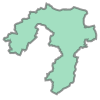

In [ ]:
# 여러 행정 구역 : '주교동', '원당동', '신원동', '원흥동', '도내동'
from shapely.ops import unary_union
row5_geometry = unary_union(dong_boundary['geometry'].iloc[0:5]) # 5개의 동 경계 합치기 
row5_geometry

In [ ]:
row5 = check_dong_index(df_target_real_plan, row5_geometry)
row5.head()

,좌표,예상 수요,청사(국가)_count,기타청소년수련시설_count,지하철_승하차수,Road_yes,공영차고지_count,여객자동차터미널_count,기타 운동장시설_count,220_count,도시철도_count,노외주차장_count,기타 주차장시설_count,일반철도_count,특수학교_count,유치원_count,고등학교_count,500_count,기타철도시설_count,DN_avg,대학_count,중학교_count,기타 도서관시설_count,종합운동장_count,250_count,기타 문화시설_count,210_count,골프장_count,200_count,지방자치단체_count,기타 사회복지시설_count,110_count,초등학교_count,310_count,버스_승하차수,기타 체육시설_count,주거인구,320_count,기타 학교시설_count,330_count,기타 연구시설_count,공공체육시설_count,기타 공공직업훈련시설_count,260_count,221_count,120_count,위도,경도,예상 수요 분위수
1314,"(37.609933339553585, 126.8572092635957)",486.79670,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,6.0,0,0,0,0,0,0,0,0,0,37.609933,126.857209,3
1367,"(37.61079289947215, 126.85491894931859)",169.97580,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,19,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,6.0,0,0,0,0,0,0,0,0,0,37.610793,126.854919,2
1368,"(37.610813483853796, 126.85605117876166)",232.55208,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,6.0,0,0,0,0,0,0,0,0,0,37.610813,126.856051,3
1369,"(37.61083405738223, 126.85718340935665)",326.08246,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,6.0,0,0,0,0,0,0,0,0,0,37.610834,126.857183,3
1370,"(37.61085462005742, 126.85831564110275)",1000.54930,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,463.0,0,6.0,0,0,0,0,0,0,0,0,0,37.610855,126.858316,5


In [ ]:
var = row5  # 위에 뽑은 해당지역 dataframe 넣기 

# 100m 기준 격자 
import folium
m = folium.Map(location=(37.66714305514331, 126.82008045013437), zoom_start=13)
folium.Choropleth(
    geo_data = dong_boundary,
    data = dong_boundary,
    columns = ('EMD_KOR_NM', '색깔'),
    key_on = 'feature.properties.EMD_KOR_NM',
    fill_color = 'BuPu',
    legend_name = '색깔',
    fill_opacity=0.5
).add_to(m)

for sub_lat, sub_long, quan, D in zip(var['위도'], var['경도'], var['예상 수요 분위수'],var['예상 수요']): 
  if quan == 1:
    color = 'white'
  elif quan == 2:
    color = 'yellow'
  elif quan == 3:
    color = 'green'
  elif quan == 4:
    color = 'blue'
  elif quan == 5:
    color = 'red'
  else:
    color = 'black'
  folium.CircleMarker([sub_lat, sub_long],
       tooltip = D, radius = 0.5 , color = color ).add_to(m)

# 자전거 스테이션 
for index, row in station.iterrows():
  title = "Station {}: # of bike {} || Total {:.2f} - Rental {:.2f} - Return {:.2f}".format(row['Station_ID'],row['거치대 수량'],row['총 이용_월평균'], row['대여_월평균'], row['반납_월평균'])
  folium.Marker([row['위도'], row['경도']], tooltip = title).add_to(m)  

m

Output hidden; open in https://colab.research.google.com to view.